In [1]:
# Notebook 3: Model Evaluation & Safety Compliance Analysis
# Construction Safety Detection

!pip install ultralytics # Install ultralytics if not already installed
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import yaml
from collections import defaultdict

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 32.6 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.



# 1. LOAD MODEL & CONFIG

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
model = YOLO('/content/drive/MyDrive/Colab Notebooks/Capstone 4/models/construction_safety_augmented/weights/best.pt')

with open('/content/drive/MyDrive/Colab Notebooks/Capstone 4/extracted/data_augmented.yaml', 'r') as f:
    config = yaml.safe_load(f)

class_names = config['names']
print("✅ Model loaded successfully")
print(f"Classes: {class_names}")

✅ Model loaded successfully
Classes: ['helmet', 'no-helmet', 'no-vest', 'person', 'vest']



# 2. INFERENCE ON TEST IMAGES

In [5]:
def predict_image(image_path, conf_threshold=0.25):
    """Predict objects in image"""
    results = model.predict(
        source=image_path,
        conf=conf_threshold,
        iou=0.45,
        verbose=False
    )
    return results[0]

# Test pada beberapa gambar
test_images = list(Path('/content/drive/MyDrive/Colab Notebooks/Capstone 4/extracted/test/images').glob('*.jpg'))[:6]

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

for idx, img_path in enumerate(test_images):
    result = predict_image(str(img_path))

    # Plot annotated image
    annotated_img = result.plot()
    annotated_img = cv2.cvtColor(annotated_img, cv2.COLOR_BGR2RGB)

    axes[idx].imshow(annotated_img)
    axes[idx].set_title(f'Prediction: {img_path.name}', fontweight='bold')
    axes[idx].axis('off')

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/Colab Notebooks/Capstone 4/results/test_predictions.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Test predictions saved")

Output hidden; open in https://colab.research.google.com to view.


# 3. SAFETY COMPLIANCE ANALYSIS

In [6]:


def analyze_safety_compliance(result):
    """
    Analisis kepatuhan keselamatan pekerja

    Logic:
    - Hitung jumlah person
    - Hitung jumlah helmet vs no-helmet
    - Hitung jumlah vest vs no-vest
    - Identifikasi pekerja yang tidak lengkap
    """
    boxes = result.boxes

    # Counter untuk setiap kelas
    counts = {
        'person': 0,
        'helmet': 0,
        'no-helmet': 0,
        'vest': 0,
        'no-vest': 0
    }

    # Hitung deteksi
    for box in boxes:
        class_id = int(box.cls[0])
        class_name = class_names[class_id]
        counts[class_name] += 1

    # Analisis compliance
    total_workers = counts['person']

    # Helmet compliance
    helmet_compliant = counts['helmet']
    helmet_violation = counts['no-helmet']

    # Vest compliance
    vest_compliant = counts['vest']
    vest_violation = counts['no-vest']

    # Total violations (pekerja yang tidak lengkap)
    # Asumsi: setiap 'no-helmet' atau 'no-vest' adalah violation
    total_violations = helmet_violation + vest_violation

    # Compliance rate
    if total_workers > 0:
        # Idealnya: setiap person harus punya helmet dan vest
        # Actual compliant: yang punya helmet DAN vest
        # Simplified: hitung berdasarkan violations
        helmet_compliance_rate = (helmet_compliant / total_workers * 100) if total_workers > 0 else 0
        vest_compliance_rate = (vest_compliant / total_workers * 100) if total_workers > 0 else 0
        overall_compliance_rate = ((helmet_compliant + vest_compliant) / (total_workers * 2) * 100) if total_workers > 0 else 0
    else:
        helmet_compliance_rate = 0
        vest_compliance_rate = 0
        overall_compliance_rate = 0

    # Safety status
    if total_violations == 0 and total_workers > 0:
        safety_status = "✅ SAFE - All workers compliant"
        status_color = "green"
    elif total_violations > 0:
        safety_status = f"⚠️ WARNING - {total_violations} violation(s) detected"
        status_color = "orange"
    else:
        safety_status = "ℹ️ No workers detected"
        status_color = "gray"

    return {
        'counts': counts,
        'total_workers': total_workers,
        'helmet_compliant': helmet_compliant,
        'helmet_violation': helmet_violation,
        'vest_compliant': vest_compliant,
        'vest_violation': vest_violation,
        'total_violations': total_violations,
        'helmet_compliance_rate': helmet_compliance_rate,
        'vest_compliance_rate': vest_compliance_rate,
        'overall_compliance_rate': overall_compliance_rate,
        'safety_status': safety_status,
        'status_color': status_color
    }



# 4. VISUALIZE SAFETY ANALYSIS

/tmp/ipython-input-3769192787.py:67: UserWarning: Glyph 127959 (\N{BUILDING CONSTRUCTION}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/tmp/ipython-input-3769192787.py:67: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/tmp/ipython-input-3769192787.py:67: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/tmp/ipython-input-3769192787.py:67: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/tmp/ipython-input-3769192787.py:67: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/tmp/ipython-input-3769192787.py:76: UserWarning: Glyph 127959 (\N{BUILDING CONSTRUCTION}) missing from font(s) DejaVu Sans Mono.
  plt.savefig('/content/drive/MyDrive/Colab Notebooks/Capstone 4/results/safety_analysis_example.png', dpi=300, bbox_inches='tight')
/tmp/ipy

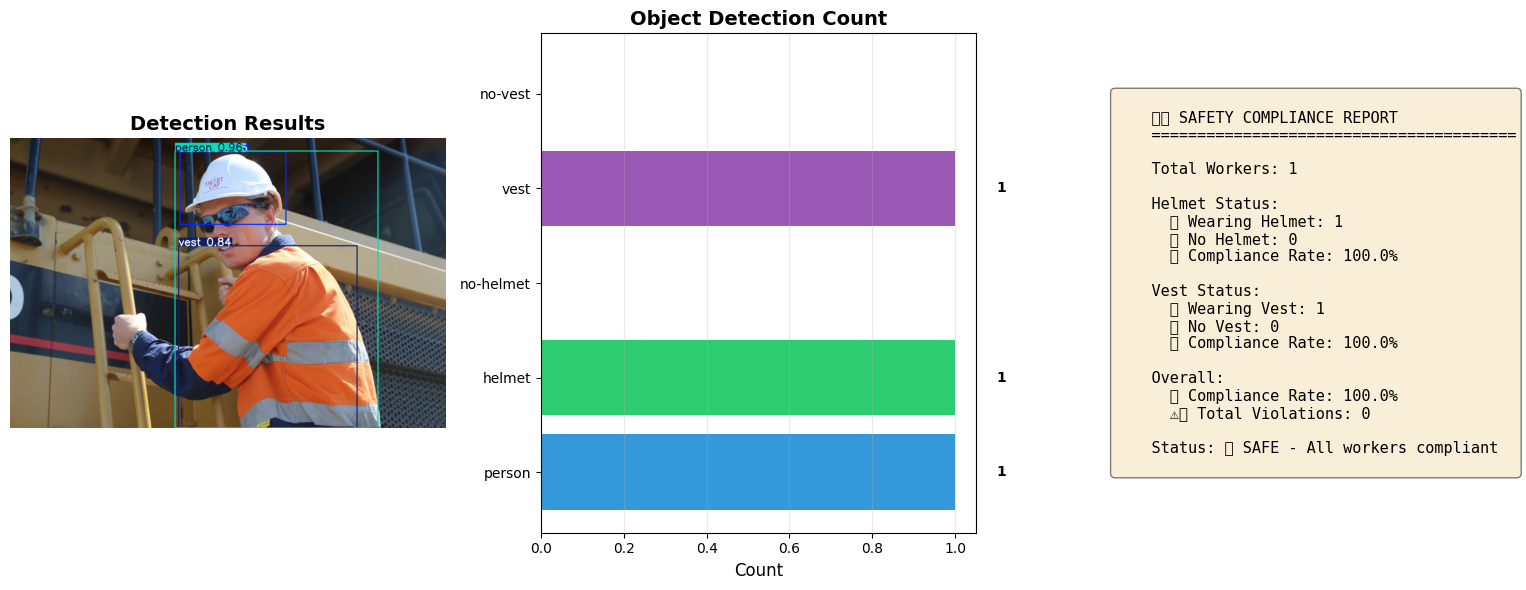


SAFETY ANALYSIS RESULT:
Image: ppe_0139_jpg.rf.7adea2f91bb1f4c2463ff07c4236dbbe.jpg
Total Workers: 1
Helmet Violations: 0
Vest Violations: 0
Overall Compliance: 100.0%
Status: ✅ SAFE - All workers compliant


In [7]:

def visualize_safety_analysis(image_path, result, analysis):
    """Visualisasi hasil analisis safety"""
    fig = plt.figure(figsize=(16, 6))

    # Plot 1: Annotated Image
    ax1 = plt.subplot(1, 3, 1)
    annotated_img = result.plot()
    annotated_img = cv2.cvtColor(annotated_img, cv2.COLOR_BGR2RGB)
    ax1.imshow(annotated_img)
    ax1.set_title('Detection Results', fontsize=14, fontweight='bold')
    ax1.axis('off')

    # Plot 2: Object Counts
    ax2 = plt.subplot(1, 3, 2)
    counts = analysis['counts']
    categories = list(counts.keys())
    values = list(counts.values())
    colors_map = {
        'person': '#3498db',
        'helmet': '#2ecc71',
        'no-helmet': '#e74c3c',
        'vest': '#9b59b6',
        'no-vest': '#f39c12'
    }
    bar_colors = [colors_map[cat] for cat in categories]

    bars = ax2.barh(categories, values, color=bar_colors)
    ax2.set_xlabel('Count', fontsize=12)
    ax2.set_title('Object Detection Count', fontsize=14, fontweight='bold')
    ax2.grid(axis='x', alpha=0.3)

    for i, (bar, val) in enumerate(zip(bars, values)):
        if val > 0:
            ax2.text(val + 0.1, i, str(val), va='center', fontweight='bold')

    # Plot 3: Compliance Report
    ax3 = plt.subplot(1, 3, 3)
    ax3.axis('off')

    report_text = f"""
    🏗️ SAFETY COMPLIANCE REPORT
    {'='*40}

    Total Workers: {analysis['total_workers']}

    Helmet Status:
      ✅ Wearing Helmet: {analysis['helmet_compliant']}
      ❌ No Helmet: {analysis['helmet_violation']}
      📊 Compliance Rate: {analysis['helmet_compliance_rate']:.1f}%

    Vest Status:
      ✅ Wearing Vest: {analysis['vest_compliant']}
      ❌ No Vest: {analysis['vest_violation']}
      📊 Compliance Rate: {analysis['vest_compliance_rate']:.1f}%

    Overall:
      📊 Compliance Rate: {analysis['overall_compliance_rate']:.1f}%
      ⚠️ Total Violations: {analysis['total_violations']}

    Status: {analysis['safety_status']}
    """

    ax3.text(0.1, 0.5, report_text, fontsize=11,
             verticalalignment='center', fontfamily='monospace',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

    plt.tight_layout()
    return fig

# Test safety analysis
sample_image = test_images[0]
result = predict_image(str(sample_image))
analysis = analyze_safety_compliance(result)

fig = visualize_safety_analysis(sample_image, result, analysis)
plt.savefig('/content/drive/MyDrive/Colab Notebooks/Capstone 4/results/safety_analysis_example.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n" + "="*60)
print("SAFETY ANALYSIS RESULT:")
print("="*60)
print(f"Image: {sample_image.name}")
print(f"Total Workers: {analysis['total_workers']}")
print(f"Helmet Violations: {analysis['helmet_violation']}")
print(f"Vest Violations: {analysis['vest_violation']}")
print(f"Overall Compliance: {analysis['overall_compliance_rate']:.1f}%")
print(f"Status: {analysis['safety_status']}")



# 5. BATCH ANALYSIS ON TEST SET

In [8]:

print("\n" + "="*60)
print("BATCH ANALYSIS ON TEST SET...")
print("="*60)

all_analyses = []

for img_path in test_images:
    result = predict_image(str(img_path))
    analysis = analyze_safety_compliance(result)
    analysis['image_name'] = img_path.name
    all_analyses.append(analysis)

# Summary statistics
total_images = len(all_analyses)
images_with_violations = sum(1 for a in all_analyses if a['total_violations'] > 0)
avg_compliance = np.mean([a['overall_compliance_rate'] for a in all_analyses])
total_workers_all = sum(a['total_workers'] for a in all_analyses)
total_violations_all = sum(a['total_violations'] for a in all_analyses)

print(f"\nTotal Images Analyzed: {total_images}")
print(f"Total Workers Detected: {total_workers_all}")
print(f"Images with Violations: {images_with_violations}")
print(f"Total Violations: {total_violations_all}")
print(f"Average Compliance Rate: {avg_compliance:.1f}%")



BATCH ANALYSIS ON TEST SET...

Total Images Analyzed: 6
Total Workers Detected: 15
Images with Violations: 3
Total Violations: 9
Average Compliance Rate: 51.4%



# 6. VISUALIZE AGGREGATE STATISTICS

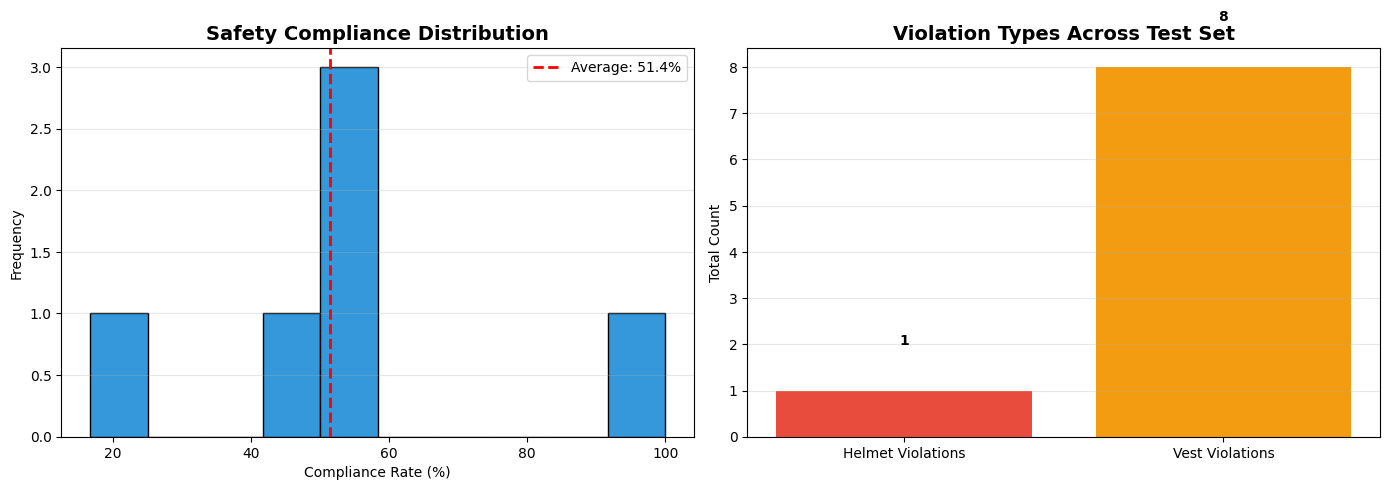


✅ Evaluation completed! All results saved in 'results' folder.

💡 Next step: Create Streamlit application for deployment!


In [9]:


fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Compliance Distribution
compliance_rates = [a['overall_compliance_rate'] for a in all_analyses]
axes[0].hist(compliance_rates, bins=10, color='#3498db', edgecolor='black')
axes[0].set_xlabel('Compliance Rate (%)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Safety Compliance Distribution', fontsize=14, fontweight='bold')
axes[0].axvline(avg_compliance, color='red', linestyle='--', linewidth=2, label=f'Average: {avg_compliance:.1f}%')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# Plot 2: Violation Types
violation_types = ['Helmet Violations', 'Vest Violations']
violation_counts = [
    sum(a['helmet_violation'] for a in all_analyses),
    sum(a['vest_violation'] for a in all_analyses)
]
colors = ['#e74c3c', '#f39c12']

axes[1].bar(violation_types, violation_counts, color=colors)
axes[1].set_ylabel('Total Count')
axes[1].set_title('Violation Types Across Test Set', fontsize=14, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

for i, v in enumerate(violation_counts):
    axes[1].text(i, v + 1, str(v), ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/Colab Notebooks/Capstone 4/results/aggregate_safety_statistics.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Evaluation completed! All results saved in 'results' folder.")
print("\n💡 Next step: Create Streamlit application for deployment!")